In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import numpy as np
from rasterio.plot import show as rasterio_show
from matplotlib_scalebar.scalebar import ScaleBar
from atl_module.utility_functions.plotting import set_size

In [3]:
# %matplotlib widget

# reading the point locations

In [15]:
site = "charlotteamalie"

In [16]:
# get a dataframe of all bathymetry points
all_df = gpd.read_file(f"../data/test_sites/{site}/all_bathy_pts.gpkg")
#  get a dataframe of the subsampled points
subset_df = gpd.read_file(f"../data/test_sites/{site}/kriging_pts/")

In [17]:
# convert to a numpy array
subset_pts = subset_df.drop(columns="geometry").to_records(index=False)

# reading the kriging output

In [18]:
krigingras = rio.open(f"../data/test_sites/{site}/kriging_output.tif")
# the sigma is the second band
uncertainty = krigingras.read(2)
# the actual bathymetry estimate is the first band
kriged_bathy = krigingras.read(1)
height = uncertainty.shape[0]
width = uncertainty.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rio.transform.xy(krigingras.transform, rows, cols)
eastings = np.array(xs)
northings = np.array(ys)

In [8]:
utm_name = subset_df.crs.name.strip("WGS 84 / ")

In [9]:
%matplotlib widget

In [19]:
# just going to manually keep track of these
initialview_params = {
    "oahu8": (18, -55),
    "florida_keys": (28, -166),
    "oahu1": (28, -117),
    "oahu2": (16, -100),
    "oahu3": (33, 6),
    "oahu4": (11, -9),
    "charlotteamalie": (11, -9),
}

# making the 3d figure

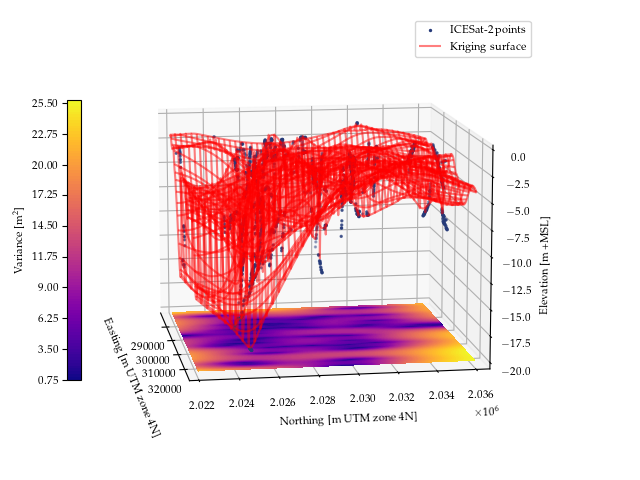

In [20]:
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(
    subset_pts.X,
    subset_pts.Y,
    subset_pts.Z,
    s=2,
    label="ICESat-2 points",
)
ax.plot_wireframe(
    eastings, northings, kriged_bathy, color="red", alpha=0.5, label="Kriging surface"
)

# find the location of the bottom of the plot based on the minimum depth of the bathymetry points:
mindepth = min(subset_pts.Z.min(), kriged_bathy.min())
xmin = min(subset_pts.X.min(), eastings.min())
xmax = max(subset_pts.X.max(), eastings.max())
ymin = min(subset_pts.Y.min(), northings.min())
ymax = max(subset_pts.Y.max(), northings.max())
contourf_artist = ax.contourf(
    eastings, northings, uncertainty, 100, offset=mindepth, zdir="z", cmap="plasma"
)

# set plot limits
ax.set_zlim3d(
    top=0,
    bottom=mindepth,
)
# ax.set_xlim3d(left=xmin,right=xmax)
ax.set_ylim3d(top=ymax, bottom=ymin)
# ax.set_aspect(1.5)

# set the view, the best view depends on the site so requires experimentation
el, az = initialview_params[site]
ax.view_init(elev=el, azim=az)
# set the labels as needed
ax.set_zlabel("Elevation [m +MSL]")
ax.set_xlabel(f"Easting [m {utm_name}]")
ax.set_ylabel(f"Northing [m {utm_name}]")
ax.legend()
fig.colorbar(
    contourf_artist,
    ax=ax,
    label="Variance [m$^2$]",
    orientation="vertical",
    fraction=0.025,
    location="left",
    pad=0.01,
)
fig.tight_layout()

In [22]:
fig.savefig(f"../data/gl_pres_data/{site}_plot_3d.pdf", bbox_inches="tight")

# making the 2d figure

(6.200787325307873, 7.381889672985563)


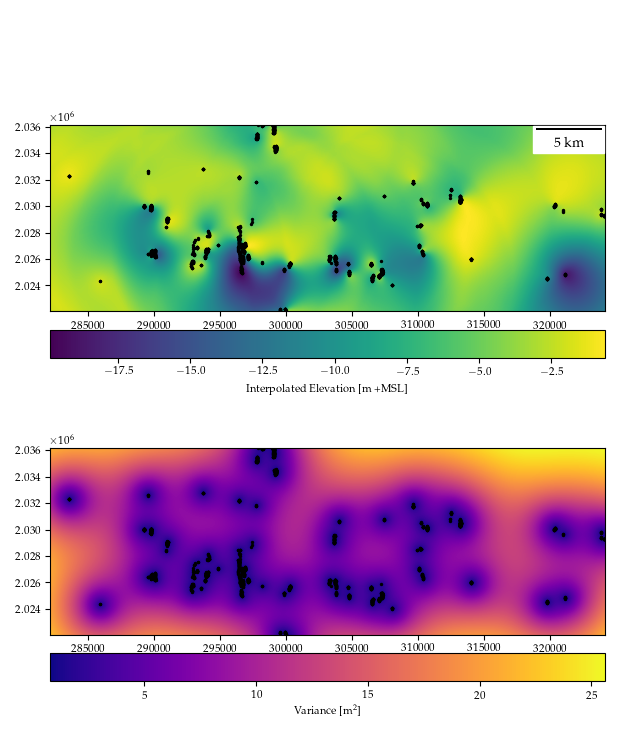

In [25]:
figsize = set_size(fraction=1, ratio=1.68 / 2)
print(figsize)


def plot_kriging_output(
    kriging_raster_dataset: rio.DatasetReader, kriging_pt_df: gpd.GeoDataFrame
):
    # set up the figure with two subplots
    fig, (ax2, ax1) = plt.subplots(nrows=2, figsize=figsize)
    # get the artists of the imageshow function for later, then clear the axes
    imartist_sigma = ax1.imshow(uncertainty, cmap="plasma")
    ax1.clear()
    imartist_elevation_surface = ax2.imshow(kriged_bathy)
    ax2.clear()
    scalebar = ScaleBar(1, units="m", location="upper right")
    ax2.add_artist(scalebar)

    # plot the points on both axes
    kriging_pt_df.plot(ax=ax1, c="black", markersize=2)
    kriging_pt_df.plot(ax=ax2, c="black", markersize=2)

    # plot the image with geo unit axes
    rasterio_show((kriging_raster_dataset, 2), ax=ax1, cmap="plasma")
    rasterio_show((kriging_raster_dataset, 1), ax=ax2)

    # add the colormaps using the artists we got before
    orientval = "horizontal"
    fig.colorbar(
        imartist_sigma,
        ax=ax1,
        label="Variance [m$^2$]",
        orientation=orientval,
        pad=0.05,
    )
    fig.colorbar(
        imartist_elevation_surface,
        ax=ax2,
        label="Interpolated Elevation [m +MSL]",
        orientation=orientval,
        pad=0.05,
    )
    fig.tight_layout()
    return fig


comparison_fig = plot_kriging_output(krigingras, kriging_pt_df=subset_df)

In [26]:
comparison_fig.savefig(
    f"../data/gl_pres_data/{site}_kriging_output.pdf", bbox_inches="tight"
)